In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [5]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


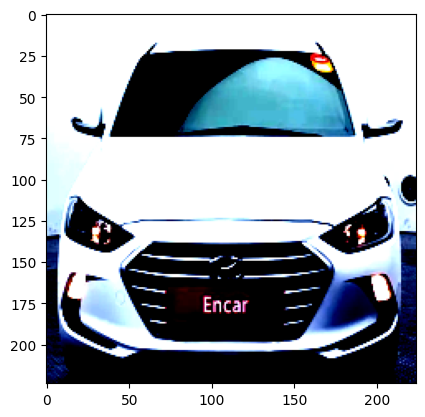

In [11]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

## Model 1: CNN

In [12]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1} Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {epoch_loss:.4f}")
        #Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += images.size(0)
                correct += (labels == predicted).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {correct / total * 100:0.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    return all_labels, all_predictions


In [14]:
train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1 Loss: 1.79
Batch: 20, Epoch: 1 Loss: 1.46
Batch: 30, Epoch: 1 Loss: 1.41
Batch: 40, Epoch: 1 Loss: 1.56
Batch: 50, Epoch: 1 Loss: 1.05
Epoch [1/5], Avg Loss: 1.6243
*** Validation Accuracy: 48.52% ***
Batch: 10, Epoch: 2 Loss: 1.05
Batch: 20, Epoch: 2 Loss: 1.00
Batch: 30, Epoch: 2 Loss: 0.92
Batch: 40, Epoch: 2 Loss: 1.01
Batch: 50, Epoch: 2 Loss: 1.31
Epoch [2/5], Avg Loss: 1.1045
*** Validation Accuracy: 52.87% ***
Batch: 10, Epoch: 3 Loss: 0.91
Batch: 20, Epoch: 3 Loss: 0.92
Batch: 30, Epoch: 3 Loss: 1.12
Batch: 40, Epoch: 3 Loss: 0.74
Batch: 50, Epoch: 3 Loss: 0.64
Epoch [3/5], Avg Loss: 0.8727
*** Validation Accuracy: 56.17% ***
Batch: 10, Epoch: 4 Loss: 0.63
Batch: 20, Epoch: 4 Loss: 0.60
Batch: 30, Epoch: 4 Loss: 0.59
Batch: 40, Epoch: 4 Loss: 0.45
Batch: 50, Epoch: 4 Loss: 0.44
Epoch [4/5], Avg Loss: 0.5840
*** Validation Accuracy: 56.70% ***
Batch: 10, Epoch: 5 Loss: 0.24
Batch: 20, Epoch: 5 Loss: 0.26
Batch: 30, Epoch: 5 Loss: 0.54
Batch: 40, Epoch: 5 Los

([5,
  4,
  5,
  2,
  0,
  4,
  5,
  3,
  0,
  0,
  3,
  5,
  4,
  2,
  0,
  2,
  0,
  2,
  2,
  1,
  0,
  0,
  4,
  3,
  2,
  0,
  2,
  2,
  1,
  2,
  1,
  0,
  1,
  3,
  3,
  3,
  0,
  1,
  2,
  5,
  3,
  2,
  2,
  3,
  0,
  0,
  4,
  3,
  0,
  4,
  5,
  4,
  0,
  3,
  1,
  0,
  2,
  2,
  5,
  4,
  2,
  3,
  4,
  1,
  0,
  2,
  3,
  2,
  1,
  1,
  5,
  0,
  3,
  0,
  2,
  0,
  3,
  1,
  2,
  5,
  2,
  0,
  0,
  3,
  5,
  1,
  5,
  2,
  0,
  2,
  0,
  5,
  2,
  3,
  1,
  3,
  2,
  4,
  2,
  0,
  1,
  2,
  4,
  3,
  0,
  1,
  4,
  1,
  4,
  3,
  1,
  1,
  4,
  2,
  5,
  3,
  2,
  1,
  5,
  4,
  5,
  1,
  4,
  3,
  4,
  0,
  0,
  4,
  4,
  5,
  2,
  5,
  5,
  1,
  0,
  1,
  4,
  2,
  0,
  0,
  2,
  5,
  2,
  0,
  1,
  1,
  4,
  0,
  4,
  0,
  2,
  2,
  1,
  0,
  0,
  2,
  4,
  2,
  1,
  4,
  2,
  3,
  5,
  0,
  1,
  1,
  5,
  2,
  4,
  2,
  0,
  3,
  2,
  0,
  3,
  4,
  0,
  3,
  4,
  1,
  1,
  4,
  1,
  1,
  4,
  3,
  1,
  5,
  2,
  1,
  0,
  2,
  1,
  0,
  4,
  2,
  4,
  4,
  2,
  0,


## Model 2: CNN with Regularization

In [15]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1 Loss: 17.15
Batch: 20, Epoch: 1 Loss: 4.12
Batch: 30, Epoch: 1 Loss: 2.00
Batch: 40, Epoch: 1 Loss: 1.39
Batch: 50, Epoch: 1 Loss: 1.36
Epoch [1/10], Avg Loss: 8.3280
*** Validation Accuracy: 47.13% ***
Batch: 10, Epoch: 2 Loss: 1.55
Batch: 20, Epoch: 2 Loss: 1.43
Batch: 30, Epoch: 2 Loss: 1.17
Batch: 40, Epoch: 2 Loss: 1.41
Batch: 50, Epoch: 2 Loss: 1.52
Epoch [2/10], Avg Loss: 1.3121
*** Validation Accuracy: 50.09% ***
Batch: 10, Epoch: 3 Loss: 1.23
Batch: 20, Epoch: 3 Loss: 1.04
Batch: 30, Epoch: 3 Loss: 1.03
Batch: 40, Epoch: 3 Loss: 0.95
Batch: 50, Epoch: 3 Loss: 1.23
Epoch [3/10], Avg Loss: 1.1664
*** Validation Accuracy: 48.87% ***
Batch: 10, Epoch: 4 Loss: 1.19
Batch: 20, Epoch: 4 Loss: 1.35
Batch: 30, Epoch: 4 Loss: 0.73
Batch: 40, Epoch: 4 Loss: 1.15
Batch: 50, Epoch: 4 Loss: 1.21
Epoch [4/10], Avg Loss: 1.0673
*** Validation Accuracy: 49.91% ***
Batch: 10, Epoch: 5 Loss: 1.15
Batch: 20, Epoch: 5 Loss: 1.04
Batch: 30, Epoch: 5 Loss: 0.81
Batch: 40, Epoch: 

([2,
  5,
  2,
  3,
  1,
  5,
  5,
  2,
  1,
  2,
  2,
  5,
  2,
  1,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  0,
  2,
  0,
  5,
  0,
  5,
  0,
  3,
  2,
  4,
  3,
  5,
  4,
  0,
  4,
  2,
  1,
  2,
  2,
  4,
  0,
  5,
  2,
  1,
  2,
  3,
  0,
  0,
  0,
  4,
  2,
  2,
  5,
  0,
  0,
  0,
  0,
  2,
  1,
  1,
  1,
  1,
  0,
  3,
  5,
  2,
  2,
  0,
  4,
  4,
  1,
  3,
  3,
  0,
  2,
  2,
  2,
  3,
  5,
  3,
  1,
  1,
  4,
  0,
  4,
  1,
  1,
  2,
  0,
  3,
  0,
  2,
  4,
  0,
  2,
  4,
  2,
  3,
  2,
  0,
  4,
  5,
  3,
  2,
  3,
  5,
  1,
  2,
  0,
  3,
  0,
  4,
  2,
  1,
  0,
  5,
  2,
  1,
  5,
  2,
  2,
  0,
  0,
  2,
  0,
  4,
  1,
  3,
  0,
  0,
  0,
  1,
  4,
  4,
  3,
  1,
  1,
  4,
  4,
  3,
  0,
  2,
  5,
  5,
  4,
  1,
  3,
  5,
  2,
  3,
  5,
  5,
  0,
  4,
  0,
  1,
  4,
  4,
  1,
  0,
  2,
  1,
  3,
  0,
  1,
  3,
  5,
  4,
  2,
  5,
  1,
  5,
  4,
  0,
  2,
  3,
  3,
  2,
  4,
  4,
  3,
  2,
  4,
  5,
  0,
  1,
  2,
  4,
  0,
  3,
  4,
  2,
  2,
  3,
  3,
  1,
  5,
  0,
  5,


## Model 3: Transfer Learning with EfficientNet


In [16]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x
    
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1 Loss: 1.67
Batch: 20, Epoch: 1 Loss: 1.60
Batch: 30, Epoch: 1 Loss: 1.37
Batch: 40, Epoch: 1 Loss: 1.42
Batch: 50, Epoch: 1 Loss: 1.34
Epoch [1/10], Avg Loss: 1.4853
*** Validation Accuracy: 57.74% ***
Batch: 10, Epoch: 2 Loss: 1.08
Batch: 20, Epoch: 2 Loss: 1.30
Batch: 30, Epoch: 2 Loss: 1.08
Batch: 40, Epoch: 2 Loss: 1.16
Batch: 50, Epoch: 2 Loss: 1.05
Epoch [2/10], Avg Loss: 1.1216
*** Validation Accuracy: 61.91% ***
Batch: 10, Epoch: 3 Loss: 1.09
Batch: 20, Epoch: 3 Loss: 0.88
Batch: 30, Epoch: 3 Loss: 1.06
Batch: 40, Epoch: 3 Loss: 1.06
Batch: 50, Epoch: 3 Loss: 1.18
Epoch [3/10], Avg Loss: 0.9777
*** Validation Accuracy: 63.65% ***
Batch: 10, Epoch: 4 Loss: 0.99
Batch: 20, Epoch: 4 Loss: 1.10
Batch: 30, Epoch: 4 Loss: 1.25
Batch: 40, Epoch: 4 Loss: 0.98
Batch: 50, Epoch: 4 Loss: 0.83
Epoch [4/10], Avg Loss: 0.9256
*** Validation Accuracy: 65.74% ***
Batch: 10, Epoch: 5 Loss: 0.97
Batch: 20, Epoch: 5 Loss: 1.02
Batch: 30, Epoch: 5 Loss: 0.81
Batch: 40, Epoch: 5

([2,
  3,
  0,
  1,
  2,
  5,
  0,
  1,
  4,
  5,
  5,
  1,
  2,
  2,
  4,
  3,
  5,
  5,
  0,
  1,
  1,
  2,
  2,
  5,
  5,
  2,
  3,
  3,
  4,
  2,
  2,
  1,
  1,
  2,
  5,
  0,
  0,
  2,
  0,
  2,
  3,
  2,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  1,
  2,
  4,
  0,
  4,
  2,
  1,
  0,
  0,
  2,
  4,
  0,
  4,
  5,
  1,
  2,
  2,
  1,
  0,
  0,
  3,
  1,
  2,
  2,
  3,
  4,
  2,
  3,
  2,
  4,
  4,
  1,
  3,
  3,
  3,
  5,
  0,
  2,
  2,
  1,
  0,
  0,
  4,
  2,
  2,
  2,
  5,
  1,
  1,
  2,
  4,
  0,
  4,
  5,
  1,
  3,
  2,
  5,
  2,
  2,
  0,
  2,
  1,
  1,
  1,
  3,
  5,
  2,
  2,
  1,
  5,
  2,
  5,
  5,
  2,
  0,
  0,
  2,
  2,
  2,
  0,
  2,
  0,
  0,
  2,
  5,
  0,
  1,
  0,
  5,
  1,
  5,
  1,
  1,
  1,
  0,
  2,
  0,
  0,
  1,
  5,
  1,
  0,
  5,
  2,
  4,
  0,
  0,
  0,
  2,
  5,
  2,
  3,
  2,
  5,
  1,
  3,
  5,
  2,
  5,
  1,
  1,
  3,
  4,
  2,
  5,
  0,
  4,
  1,
  1,
  4,
  2,
  1,
  2,
  5,
  0,
  1,
  0,
  0,
  2,
  3,
  0,
  1,
  0,
  4,
  1,
  0,
  1,
  4,
  0,


## Model 4: Transfer Learning with ResNet


In [17]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights="DEFAULT")

        #Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
        #Unfreeze layer 4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        #Replace the final fc layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1 Loss: 1.02
Batch: 20, Epoch: 1 Loss: 0.81
Batch: 30, Epoch: 1 Loss: 0.59
Batch: 40, Epoch: 1 Loss: 0.69
Batch: 50, Epoch: 1 Loss: 0.59
Epoch [1/10], Avg Loss: 0.8621
*** Validation Accuracy: 68.00% ***
Batch: 10, Epoch: 2 Loss: 0.30
Batch: 20, Epoch: 2 Loss: 0.39
Batch: 30, Epoch: 2 Loss: 0.33
Batch: 40, Epoch: 2 Loss: 0.56
Batch: 50, Epoch: 2 Loss: 0.43
Epoch [2/10], Avg Loss: 0.3749
*** Validation Accuracy: 73.91% ***
Batch: 10, Epoch: 3 Loss: 0.18
Batch: 20, Epoch: 3 Loss: 0.08
Batch: 30, Epoch: 3 Loss: 0.08
Batch: 40, Epoch: 3 Loss: 0.15
Batch: 50, Epoch: 3 Loss: 0.33
Epoch [3/10], Avg Loss: 0.1833
*** Validation Accuracy: 74.26% ***
Batch: 10, Epoch: 4 Loss: 0.23
Batch: 20, Epoch: 4 Loss: 0.13
Batch: 30, Epoch: 4 Loss: 0.06
Batch: 40, Epoch: 4 Loss: 0.03
Batch: 50, Epoch: 4 Loss: 0.36
Epoch [4/10], Avg Loss: 0.0976
*** Validation Accuracy: 79.83% ***
Batch: 10, Epoch: 5 Loss: 0.24
Batch: 20, Epoch: 5 Loss: 0.24
Batch: 30, Epoch: 5 Loss: 0.06
Batch: 40, Epoch: 5

([2,
  1,
  5,
  4,
  0,
  4,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  5,
  3,
  3,
  1,
  1,
  5,
  1,
  4,
  4,
  4,
  2,
  1,
  1,
  1,
  0,
  0,
  0,
  3,
  2,
  3,
  5,
  0,
  5,
  1,
  1,
  5,
  3,
  0,
  4,
  2,
  5,
  1,
  5,
  0,
  1,
  1,
  3,
  0,
  1,
  4,
  0,
  3,
  3,
  5,
  1,
  3,
  2,
  5,
  0,
  5,
  4,
  2,
  0,
  0,
  0,
  2,
  1,
  0,
  1,
  2,
  1,
  5,
  5,
  3,
  4,
  5,
  2,
  2,
  4,
  0,
  2,
  5,
  2,
  5,
  2,
  2,
  3,
  5,
  2,
  1,
  1,
  3,
  0,
  4,
  0,
  2,
  1,
  1,
  1,
  2,
  5,
  5,
  3,
  0,
  2,
  0,
  1,
  1,
  1,
  5,
  1,
  4,
  2,
  0,
  2,
  3,
  2,
  4,
  1,
  1,
  5,
  4,
  2,
  1,
  4,
  3,
  5,
  1,
  1,
  2,
  1,
  0,
  2,
  2,
  0,
  1,
  1,
  5,
  2,
  2,
  2,
  3,
  3,
  1,
  5,
  2,
  4,
  3,
  1,
  0,
  5,
  5,
  4,
  3,
  2,
  4,
  5,
  3,
  0,
  0,
  3,
  0,
  4,
  0,
  2,
  5,
  0,
  4,
  1,
  0,
  2,
  1,
  4,
  3,
  2,
  1,
  1,
  1,
  5,
  4,
  2,
  2,
  0,
  0,
  2,
  3,
  1,
  4,
  4,
  0,
  2,
  5,
  5,
  1,
  3,
  0,
  2,
